# SFFD Calls for Service

In this notebook, we'll be looking at data from the DataSF portal. For the data set, we'll be using Fire Department Calls For Service (https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3). This is a subset of the full data set also located on the DataSF website, but this subset has only some of the 5 million rows in the full dataset. 

tl;dr: Here is a summary of everything that is happening in this notebook:

Packages used:
 * ```folium```
 * ```geopy```
 * and a couple other more standard libraries

Key Takeaways:
 * Found response times and used them to build a ```folium``` map to find slow calls and determine the cause of these slow responses.
 * Performed lots of data cleaning, munging, etc.
 * Used ```seaborn``` to make some visualizations of response times.
 * Analyzed where calls were coming from and found the Tenderloin had the highest number of calls.
 * Used response times and ```folium``` heat maps to find that it would be beneficial to San Francisco to have a fire station in the Tenderloin.
 
Things I Learned:
 * I learned that I should get to know the data before and while doing EDA. So much headache would have been avoided if I had just analyzed the data more early on.
 * ```folium``` is my new favorite package

We'll start by importing some libraries and setting some plotting settings.

In [560]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")
%matplotlib inline

Let's start by reading in the data as a CSV file using ```pd.read_csv```

In [561]:
sffd_data="https://data.sfgov.org/resource/nuek-vuh3.csv"

sffd=pd.read_csv(sffd_data)

sffd.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,...,:@computed_region_bh8s_q3mv,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_n4xg_c4py,:@computed_region_fcz8_est8,:@computed_region_h4ep_8xdi,:@computed_region_jwn9_ihcz,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq
0,63050417,T13,6086115,Alarms,2006-11-01T00:00:00.000,2006-11-01T21:12:46.000,2006-11-01T21:11:50.000,2006-11-01T21:12:46.000,2006-11-01T21:12:57.000,2006-11-01T21:14:50.000,...,28860,6.0,1.0,NaN,NaN,NaN,108.0,108.0,6.0,3.0
1,62780250,E29,6078299,Marine Fire,2006-10-05T00:00:00.000,2006-10-05T15:05:17.000,2006-10-05T15:03:39.000,2006-10-05T15:05:17.000,2006-10-05T15:06:53.000,2006-10-05T15:08:43.000,...,28860,6.0,1.0,NaN,NaN,NaN,77.0,77.0,6.0,3.0
2,63110110,E02,6087712,Medical Incident,2006-11-07T00:00:00.000,2006-11-07T08:51:32.000,2006-11-07T08:50:56.000,2006-11-07T08:51:32.000,2006-11-07T08:52:44.000,2006-11-07T08:53:47.000,...,308,4.0,1.0,NaN,NaN,NaN,104.0,104.0,6.0,3.0
3,62000391,M07,6056185,Medical Incident,2006-07-19T00:00:00.000,2006-07-19T23:06:00.000,2006-07-19T23:03:56.000,2006-07-19T23:06:00.000,2006-07-19T23:06:45.000,2006-07-19T23:07:00.000,...,28853,19.0,4.0,NaN,NaN,NaN,37.0,37.0,3.0,5.0
4,63060460,86,6086486,Medical Incident,2006-11-02T00:00:00.000,2006-11-02T23:38:31.000,2006-11-02T23:36:04.000,2006-11-02T23:38:31.000,2006-11-02T23:41:14.000,2006-11-02T23:41:29.000,...,28852,10.0,9.0,1.0,1.0,NaN,26.0,26.0,4.0,11.0


The data looks like it is mostly okay. We'll do some cleaning later on. For now, let's look at some of the stats about the data set.

In [562]:
sffd_rows=sffd.shape[0]
sffd_cols=sffd.shape[1]

print("There are",sffd_rows,"rows and",sffd_cols,"columns in this data set")

There are 1000 rows and 49 columns in this data set


In [563]:
list(sffd)

['call_number',
 'unit_id',
 'incident_number',
 'call_type',
 'call_date',
 'watch_date',
 'received_dttm',
 'entry_dttm',
 'dispatch_dttm',
 'response_dttm',
 'on_scene_dttm',
 'transport_dttm',
 'hospital_dttm',
 'call_final_disposition',
 'available_dttm',
 'address',
 'city',
 'zipcode_of_incident',
 'battalion',
 'station_area',
 'box',
 'original_priority',
 'priority',
 'final_priority',
 'als_unit',
 'call_type_group',
 'number_of_alarms',
 'unit_type',
 'unit_sequence_in_call_dispatch',
 'fire_prevention_district',
 'supervisor_district',
 'neighborhoods_analysis_boundaries',
 'location',
 'rowid',
 'shape',
 ':@computed_region_rxqg_mtj9',
 ':@computed_region_yftq_j783',
 ':@computed_region_jx4q_fizf',
 ':@computed_region_ajp5_b2md',
 ':@computed_region_bh8s_q3mv',
 ':@computed_region_fyvs_ahh9',
 ':@computed_region_p5aj_wyqh',
 ':@computed_region_n4xg_c4py',
 ':@computed_region_fcz8_est8',
 ':@computed_region_h4ep_8xdi',
 ':@computed_region_jwn9_ihcz',
 ':@computed_region_6q

49 Columns. That's a lot. Some of them seem more self explanatory than others. Thankfully, the DataSF portal gives us a key for what each of these columns means.


| Field Name | Data Type | Definition |
| :- | :- | :- |
| Call Number |	Text	|A unique 9-digit number assigned by the 911 Dispatch Center (DEM) to this call. These number are used for both Police and Fire calls.
|Unit ID|	Text|	Unit Identifier. For example E01 for Engine 1 or T01 for Truck 1.
|Incident Number	|Text|	A unique 8-digit number assigned by DEM to this Fire incident.
|Call Date	|Date & Time|	Date the call is received at the 911 Dispatch Center. Used for reporting purposes.
|Call Type|	Text	|Type of call the incident falls into. See the list below.
|Watch Date|	Date & Time	|Watch date when the call is received. Watch date starts at 0800 each morning and ends at 0800 the next day.
|Received DtTm|	Date & Time	|Date and time of call is received at the 911 Dispatch Center.
|Entry DtTm	|Date & Time|	Date and time the 911 operator submits the entry of the initical call information into the CAD system
|Dispatch DtTm	|Date & Time|	Date and time the 911 operator dispatches this unit to the call.
|Response DtTm|	Date & Time	|Date and time this unit acknowledges the dispatch and records that the unit is en route to the location of the call.
|On Scene DtTm	|Date & Time	|Date and time the unit records arriving to the location of the incident
|AVL Validated On Scene DtTm	|Date & Time|	Updated date and time the unit arrived on scene based on existing unit AVL coordinates.
|Transport DtTm	|Date & Time|	If this unit is an ambulance, date and time the unit begins the transport unit arrives to hospital
|Hospital DtTm|	Date & Time|	If this unit is an ambulance, date and time the unit arrives to the hospital.
|Call Final Disposition|	Text|	Disposition of the call (Code). For example TH2: Transport to Hospital - Code 2, FIR: Resolved by Fire Department
|Available DtTm|	Date & Time	|Date and time this unit is not longer assigned to this call and it is available for another dispatch.
|Address|	Text	|Address of midblock point associated with incident (obfuscated address to protect caller privacy)
|City	|Text	|City of incident
|Zipcode of Incident|	Text|	Zipcode of incident
|Battalion|	Text|	Emergency Response District (There are 9 Fire Emergency Response Districts)
|Station Area|	Text|	Fire Station First Response Area associated with the address of the incident
|Box|	Text|	Fire box associated with the address of the incident. A box is the smallest area used to divide the City. Each box is associated with a unique unit dispatch order. The City is divided into more than 2,400 boxes.
|Original Priority|	Text|	Initial call priority (Code 2: Non-Emergency or Code 3:Emergency).
|Priority|	Text|	Call priority (Code 2: Non-Emergency or Code 3:Emergency).
|Final Priority|	Text|	Final call priority (Code 2: Non-Emergency or Code 3:Emergency).
|ALS Unit	|Boolean (True/False)|	Does this unit includes ALS (Advance Life Support) resources? Is there a paramedic in this unit?
|Call Type Group	|Text|	Call types are divided into four main groups: Fire, Alarm, Potential Life Threatening and Non Life Threatening.
|Number of Alarms	|Numeric|	Number of alarms associated with the incident. This is a number between 1 and 5.
|Unit Type	|Text|	Unit type
|Unit sequence in call dispatch	|Numeric|	A number that indicates the order this unit was assigned to this call
|Location	|Coordinates|	Latitude and longitude of address obfuscated either to the midblock, intersection or call box
|Fire Prevention District|	Text|	Bureau of Fire Prevention District associated with this address
|Supervisor District	|Text	|Supervisor District associated with this address
|Neighborhood District|	Text|	Neighborhood District associated with this address, boundaries available here: https://data.sfgov.org/d/p5b7-5n3h
|RowID	|Text|	Unique identifier used for managing data updates. It is the concatenation of Call Number and Unit ID separated by a dash


Seems like we have some columns in the data set that aren't in the key. Let's see what's up with those columns:

In [564]:
sffd[['shape',
 ':@computed_region_rxqg_mtj9',
 ':@computed_region_yftq_j783',
 ':@computed_region_jx4q_fizf',
 ':@computed_region_ajp5_b2md',
 ':@computed_region_bh8s_q3mv',
 ':@computed_region_fyvs_ahh9',
 ':@computed_region_p5aj_wyqh',
 ':@computed_region_n4xg_c4py',
 ':@computed_region_fcz8_est8',
 ':@computed_region_h4ep_8xdi',
 ':@computed_region_jwn9_ihcz',
 ':@computed_region_6qbp_sg9q',
 ':@computed_region_qgnn_b9vv',
 ':@computed_region_26cr_cadq']]

,shape,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_jx4q_fizf,:@computed_region_ajp5_b2md,:@computed_region_bh8s_q3mv,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_n4xg_c4py,:@computed_region_fcz8_est8,:@computed_region_h4ep_8xdi,:@computed_region_jwn9_ihcz,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq
0,POINT (-122.398205964751 37.793488084658),10.0,4.0,1.0,8.0,28860,6.0,1.0,NaN,NaN,NaN,108.0,108.0,6.0,3.0
1,POINT (-122.400706378791 37.802378366663),10.0,3.0,1.0,8.0,28860,6.0,1.0,NaN,NaN,NaN,77.0,77.0,6.0,3.0
2,POINT (-122.408014703843 37.796699717573),10.0,3.0,1.0,6.0,308,4.0,1.0,NaN,NaN,NaN,104.0,104.0,6.0,3.0
3,POINT (-122.426119884424 37.767958636664),5.0,8.0,7.0,20.0,28853,19.0,4.0,NaN,NaN,NaN,37.0,37.0,3.0,5.0
4,POINT (-122.422522963231 37.774309170905),11.0,7.0,6.0,9.0,28852,10.0,9.0,1.0,1.0,NaN,26.0,26.0,4.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,POINT (-122.403956804569 37.794505427206),10.0,3.0,1.0,6.0,28860,4.0,1.0,NaN,NaN,NaN,104.0,104.0,6.0,3.0
996,POINT (-122.424360895464 37.792412107081),1.0,13.0,6.0,30.0,28858,27.0,9.0,NaN,NaN,NaN,102.0,102.0,4.0,6.0
997,POINT (-122.408385745499 37.780792080275),9.0,14.0,2.0,34.0,28853,34.0,2.0,1.0,1.0,1.0,32.0,32.0,1.0,10.0
998,POINT (-122.417915793747 37.793235074749),10.0,5.0,1.0,32.0,28858,32.0,1.0,NaN,NaN,NaN,16.0,16.0,6.0,3.0


Interesting. Let's take a look to see if these columns are intentionally there, or are errors of some type.

In [565]:
sffd[["location","shape"]].head()

,location,shape
0,"(37.793488084658, -122.398205964751)",POINT (-122.398205964751 37.793488084658)
1,"(37.802378366663, -122.400706378791)",POINT (-122.400706378791 37.802378366663)
2,"(37.796699717573, -122.408014703843)",POINT (-122.408014703843 37.796699717573)
3,"(37.767958636664, -122.426119884424)",POINT (-122.426119884424 37.767958636664)
4,"(37.774309170905, -122.422522963231)",POINT (-122.422522963231 37.774309170905)


Seems like ```location``` and ```shape``` are related. They seem the same except lattitude and longitude are swapped and POINT is added. (This is supposed to be used for GeoJSON) Since we already have location data, it's probably okay to drop the ```shape``` column from our DataFrame.

In [566]:
sffd=sffd.drop("shape",axis=1) #This line is a comment to avoid errors when running the cell after the shape was dropped.
sffd.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,...,:@computed_region_bh8s_q3mv,:@computed_region_fyvs_ahh9,:@computed_region_p5aj_wyqh,:@computed_region_n4xg_c4py,:@computed_region_fcz8_est8,:@computed_region_h4ep_8xdi,:@computed_region_jwn9_ihcz,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq
0,63050417,T13,6086115,Alarms,2006-11-01T00:00:00.000,2006-11-01T21:12:46.000,2006-11-01T21:11:50.000,2006-11-01T21:12:46.000,2006-11-01T21:12:57.000,2006-11-01T21:14:50.000,...,28860,6.0,1.0,NaN,NaN,NaN,108.0,108.0,6.0,3.0
1,62780250,E29,6078299,Marine Fire,2006-10-05T00:00:00.000,2006-10-05T15:05:17.000,2006-10-05T15:03:39.000,2006-10-05T15:05:17.000,2006-10-05T15:06:53.000,2006-10-05T15:08:43.000,...,28860,6.0,1.0,NaN,NaN,NaN,77.0,77.0,6.0,3.0
2,63110110,E02,6087712,Medical Incident,2006-11-07T00:00:00.000,2006-11-07T08:51:32.000,2006-11-07T08:50:56.000,2006-11-07T08:51:32.000,2006-11-07T08:52:44.000,2006-11-07T08:53:47.000,...,308,4.0,1.0,NaN,NaN,NaN,104.0,104.0,6.0,3.0
3,62000391,M07,6056185,Medical Incident,2006-07-19T00:00:00.000,2006-07-19T23:06:00.000,2006-07-19T23:03:56.000,2006-07-19T23:06:00.000,2006-07-19T23:06:45.000,2006-07-19T23:07:00.000,...,28853,19.0,4.0,NaN,NaN,NaN,37.0,37.0,3.0,5.0
4,63060460,86,6086486,Medical Incident,2006-11-02T00:00:00.000,2006-11-02T23:38:31.000,2006-11-02T23:36:04.000,2006-11-02T23:38:31.000,2006-11-02T23:41:14.000,2006-11-02T23:41:29.000,...,28852,10.0,9.0,1.0,1.0,NaN,26.0,26.0,4.0,11.0


If we Google the other column names, we see that they seem to be artifacts of Socrata, the company that DataSF uses to host and manage their data. Since these columns aren't in the data set key, we will exclude them as well.

In [567]:
sffd=sffd.drop([':@computed_region_rxqg_mtj9',
 ':@computed_region_yftq_j783',
 ':@computed_region_jx4q_fizf',
 ':@computed_region_ajp5_b2md',
 ':@computed_region_bh8s_q3mv',
 ':@computed_region_fyvs_ahh9',
 ':@computed_region_p5aj_wyqh',
 ':@computed_region_n4xg_c4py',
 ':@computed_region_fcz8_est8',
 ':@computed_region_h4ep_8xdi',
 ':@computed_region_jwn9_ihcz',
 ':@computed_region_6qbp_sg9q',
 ':@computed_region_qgnn_b9vv',
 ':@computed_region_26cr_cadq'],axis=1) #This line is a comment to avoid errors when running the cell after the shape was dropped.
sffd.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,...,als_unit,call_type_group,number_of_alarms,unit_type,unit_sequence_in_call_dispatch,fire_prevention_district,supervisor_district,neighborhoods_analysis_boundaries,location,rowid
0,63050417,T13,6086115,Alarms,2006-11-01T00:00:00.000,2006-11-01T21:12:46.000,2006-11-01T21:11:50.000,2006-11-01T21:12:46.000,2006-11-01T21:12:57.000,2006-11-01T21:14:50.000,...,True,NaN,1,TRUCK,1,1,3,Financial District/South Beach,"(37.793488084658, -122.398205964751)",063050417-T13
1,62780250,E29,6078299,Marine Fire,2006-10-05T00:00:00.000,2006-10-05T15:05:17.000,2006-10-05T15:03:39.000,2006-10-05T15:05:17.000,2006-10-05T15:06:53.000,2006-10-05T15:08:43.000,...,True,NaN,1,ENGINE,16,1,3,Financial District/South Beach,"(37.802378366663, -122.400706378791)",062780250-E29
2,63110110,E02,6087712,Medical Incident,2006-11-07T00:00:00.000,2006-11-07T08:51:32.000,2006-11-07T08:50:56.000,2006-11-07T08:51:32.000,2006-11-07T08:52:44.000,2006-11-07T08:53:47.000,...,False,NaN,1,ENGINE,1,1,3,Chinatown,"(37.796699717573, -122.408014703843)",063110110-E02
3,62000391,M07,6056185,Medical Incident,2006-07-19T00:00:00.000,2006-07-19T23:06:00.000,2006-07-19T23:03:56.000,2006-07-19T23:06:00.000,2006-07-19T23:06:45.000,2006-07-19T23:07:00.000,...,True,NaN,1,MEDIC,1,2,8,Mission,"(37.767958636664, -122.426119884424)",062000391-M07
4,63060460,86,6086486,Medical Incident,2006-11-02T00:00:00.000,2006-11-02T23:38:31.000,2006-11-02T23:36:04.000,2006-11-02T23:38:31.000,2006-11-02T23:41:14.000,2006-11-02T23:41:29.000,...,True,NaN,1,MEDIC,1,2,5,Hayes Valley,"(37.774309170905, -122.422522963231)",063060460-86


In [569]:
all(pd.unique(sffd["call_number"]))

True

The ```call_number``` is unique. This will probably be our primary key.

# Analyzing Response Times

Now that we have our DataFrame in order, we can start doing things with the data. We'll start by working with some of the datetime objects.

In [570]:
sffd["recieved dt"]=pd.to_datetime(sffd["received_dttm"])
sffd["on scene dt"]=pd.to_datetime(sffd["on_scene_dttm"])
sffd.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,...,number_of_alarms,unit_type,unit_sequence_in_call_dispatch,fire_prevention_district,supervisor_district,neighborhoods_analysis_boundaries,location,rowid,recieved dt,on scene dt
0,63050417,T13,6086115,Alarms,2006-11-01T00:00:00.000,2006-11-01T21:12:46.000,2006-11-01T21:11:50.000,2006-11-01T21:12:46.000,2006-11-01T21:12:57.000,2006-11-01T21:14:50.000,...,1,TRUCK,1,1,3,Financial District/South Beach,"(37.793488084658, -122.398205964751)",063050417-T13,2006-11-01 21:11:50,2006-11-01 21:16:07
1,62780250,E29,6078299,Marine Fire,2006-10-05T00:00:00.000,2006-10-05T15:05:17.000,2006-10-05T15:03:39.000,2006-10-05T15:05:17.000,2006-10-05T15:06:53.000,2006-10-05T15:08:43.000,...,1,ENGINE,16,1,3,Financial District/South Beach,"(37.802378366663, -122.400706378791)",062780250-E29,2006-10-05 15:03:39,NaT
2,63110110,E02,6087712,Medical Incident,2006-11-07T00:00:00.000,2006-11-07T08:51:32.000,2006-11-07T08:50:56.000,2006-11-07T08:51:32.000,2006-11-07T08:52:44.000,2006-11-07T08:53:47.000,...,1,ENGINE,1,1,3,Chinatown,"(37.796699717573, -122.408014703843)",063110110-E02,2006-11-07 08:50:56,2006-11-07 08:55:41
3,62000391,M07,6056185,Medical Incident,2006-07-19T00:00:00.000,2006-07-19T23:06:00.000,2006-07-19T23:03:56.000,2006-07-19T23:06:00.000,2006-07-19T23:06:45.000,2006-07-19T23:07:00.000,...,1,MEDIC,1,2,8,Mission,"(37.767958636664, -122.426119884424)",062000391-M07,2006-07-19 23:03:56,2006-07-19 23:12:36
4,63060460,86,6086486,Medical Incident,2006-11-02T00:00:00.000,2006-11-02T23:38:31.000,2006-11-02T23:36:04.000,2006-11-02T23:38:31.000,2006-11-02T23:41:14.000,2006-11-02T23:41:29.000,...,1,MEDIC,1,2,5,Hayes Valley,"(37.774309170905, -122.422522963231)",063060460-86,2006-11-02 23:36:04,2006-11-02 23:44:46


Now we have columns called with date time objects! Let's see when the earliest and latest call was

In [571]:
sffd["date"]=sffd["recieved dt"].dt.date
earliest_date=sffd.sort_values(["recieved dt"],ascending=True).iloc[0]["date"]
latest_date=sffd.sort_values(["recieved dt"],ascending=False).iloc[0]["date"]

print("The earliest call was on",earliest_date, "and the latest call was on",latest_date)

The earliest call was on 2006-06-07 and the latest call was on 2007-04-27


Let's see if we can take a look at the response time of each call using the ```received_dttm``` and ```on_scene_dttm``` columns

In [572]:

sffd["recieved time"]=sffd["recieved dt"].dt.time
sffd["on scene time"]=sffd["on scene dt"].dt.time
sffd["response time"]=(sffd["on scene dt"]-sffd["recieved dt"])/np.timedelta64(1,"m")
sffd.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,...,supervisor_district,neighborhoods_analysis_boundaries,location,rowid,recieved dt,on scene dt,date,recieved time,on scene time,response time
0,63050417,T13,6086115,Alarms,2006-11-01T00:00:00.000,2006-11-01T21:12:46.000,2006-11-01T21:11:50.000,2006-11-01T21:12:46.000,2006-11-01T21:12:57.000,2006-11-01T21:14:50.000,...,3,Financial District/South Beach,"(37.793488084658, -122.398205964751)",063050417-T13,2006-11-01 21:11:50,2006-11-01 21:16:07,2006-11-01,21:11:50,21:16:07,4.283333
1,62780250,E29,6078299,Marine Fire,2006-10-05T00:00:00.000,2006-10-05T15:05:17.000,2006-10-05T15:03:39.000,2006-10-05T15:05:17.000,2006-10-05T15:06:53.000,2006-10-05T15:08:43.000,...,3,Financial District/South Beach,"(37.802378366663, -122.400706378791)",062780250-E29,2006-10-05 15:03:39,NaT,2006-10-05,15:03:39,NaT,NaN
2,63110110,E02,6087712,Medical Incident,2006-11-07T00:00:00.000,2006-11-07T08:51:32.000,2006-11-07T08:50:56.000,2006-11-07T08:51:32.000,2006-11-07T08:52:44.000,2006-11-07T08:53:47.000,...,3,Chinatown,"(37.796699717573, -122.408014703843)",063110110-E02,2006-11-07 08:50:56,2006-11-07 08:55:41,2006-11-07,08:50:56,08:55:41,4.750000
3,62000391,M07,6056185,Medical Incident,2006-07-19T00:00:00.000,2006-07-19T23:06:00.000,2006-07-19T23:03:56.000,2006-07-19T23:06:00.000,2006-07-19T23:06:45.000,2006-07-19T23:07:00.000,...,8,Mission,"(37.767958636664, -122.426119884424)",062000391-M07,2006-07-19 23:03:56,2006-07-19 23:12:36,2006-07-19,23:03:56,23:12:36,8.666667
4,63060460,86,6086486,Medical Incident,2006-11-02T00:00:00.000,2006-11-02T23:38:31.000,2006-11-02T23:36:04.000,2006-11-02T23:38:31.000,2006-11-02T23:41:14.000,2006-11-02T23:41:29.000,...,5,Hayes Valley,"(37.774309170905, -122.422522963231)",063060460-86,2006-11-02 23:36:04,2006-11-02 23:44:46,2006-11-02,23:36:04,23:44:46,8.700000


Now that we have the ```response time``` column, let's take a look at the fastest and slowest response time.

In [573]:
zero_resp=pd.DataFrame()
zero_resp=sffd.sort_values("response time")[["recieved dt","on scene dt","response time","location","call_type","call_number"]].head(13)
zero_resp

,recieved dt,on scene dt,response time,location,call_type,call_number
481,2006-09-25 15:53:35,2006-09-25 15:53:35,0.0,"(37.810520722521, -122.365138272289)",Medical Incident,62680307
149,2006-11-12 12:46:37,2006-11-12 12:46:37,0.0,"(37.709923179136, -122.405685366423)",Citizen Assist / Service Call,63160167
338,2006-10-31 13:14:15,2006-10-31 13:14:15,0.0,"(37.732438658676, -122.405607549199)",Medical Incident,63040187
940,2006-06-27 02:00:15,2006-06-27 02:00:15,0.0,"(37.774294397243, -122.420759894063)",Medical Incident,61780020
358,2006-06-13 10:13:23,2006-06-13 10:13:23,0.0,"(37.751283795816, -122.406657617867)",Medical Incident,61640148
202,2006-07-22 17:13:46,2006-07-22 17:13:46,0.0,"(37.743051813544, -122.475644467981)",Medical Incident,62030300
451,2006-06-14 15:38:30,2006-06-14 15:38:30,0.0,"(37.805550799113, -122.425219186379)",Medical Incident,61650271
450,2006-11-01 14:31:29,2006-11-01 14:31:29,0.0,"(37.788293192005, -122.408401551902)",Medical Incident,63050285
378,2006-08-27 11:33:08,2006-08-27 11:33:08,0.0,"(37.778326831465, -122.396530638158)",Medical Incident,62390124
536,2006-09-18 13:19:40,2006-09-18 13:19:40,0.0,"(37.789901610048, -122.426449179757)",Alarms,62610195


Seems like there are some calls where the response time is 0. That's pretty fast. Let's see why the response is so fast.

In [574]:
zero_resp["lat"]=pd.to_numeric(zero_resp["location"].str[1:15]) #Commented out to avoid repeat run issues
zero_resp["long"]=pd.to_numeric(zero_resp["location"].str[17:32])
zero_resp["location"]=zero_resp[["lat","long"]].values.tolist()
station_list=pd.DataFrame(np.array([[37.795651, -122.401462],[37.797029, -122.410040],[37.826848, -122.369405],[37.801627, -122.455431],[37.793496, -122.416186],[37.774959, -122.421228],[37.777192, -122.396667],[37.731623, -122.405443],[37.747623, -122.475189],[37.789665, -122.429961],[37.716654, -122.400489],[37.757411, -122.399251]]),columns=["fire station lat","fire station long"])
station_list["lat long"]=station_list[["fire station lat","fire station long"]].values.tolist()

In [575]:
import folium
import folium.plugins

sf_coords = (37.756139, -122.433819)
sf_map = folium.Map(location=sf_coords, zoom_start=12)
for k in zero_resp["location"]:
    folium.Marker(k,icon=folium.Icon(color="red",icon="exclamation-triangle",prefix="fa")).add_to(sf_map)
    
for i in station_list["lat long"]:
    folium.Marker(i,icon=folium.Icon(color="blue",icon="fire-extinguisher",prefix="fa")).add_to(sf_map)
print("Red = Call Location ///","Blue = Fire Station Location")
sf_map

Red = Call Location /// Blue = Fire Station Location


So it seems that most of the calls with a zero second have a response time are within a couple of blocks from the call location. There is one point where the location is the fire house itself. More likely than not, a truck was already nearby or the "call" originated at a fire house. However, there are some calls where there is no fire station nearby. Let's take a look at those call locations. 

In [576]:
bad_values=sffd.sort_values("response time")[["call_number","call_date","watch_date","received_dttm","entry_dttm","dispatch_dttm","response_dttm",'on_scene_dttm']].head(13)
bad_values

,call_number,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,on_scene_dttm
481,62680307,2006-09-25T00:00:00.000,2006-09-25T15:53:35.000,2006-09-25T15:53:35.000,2006-09-25T15:53:35.000,2006-09-25T15:53:35.000,NaN,2006-09-25T15:53:35.000
149,63160167,2006-11-12T00:00:00.000,2006-11-12T12:46:37.000,2006-11-12T12:46:37.000,2006-11-12T12:46:37.000,2006-11-12T12:46:37.000,NaN,2006-11-12T12:46:37.000
338,63040187,2006-10-31T00:00:00.000,2006-10-31T13:14:15.000,2006-10-31T13:14:15.000,2006-10-31T13:14:15.000,2006-10-31T13:14:15.000,NaN,2006-10-31T13:14:15.000
940,61780020,2006-06-27T00:00:00.000,2006-06-26T02:00:15.000,2006-06-27T02:00:15.000,2006-06-27T02:00:15.000,2006-06-27T02:00:15.000,NaN,2006-06-27T02:00:15.000
358,61640148,2006-06-13T00:00:00.000,2006-06-13T10:13:23.000,2006-06-13T10:13:23.000,2006-06-13T10:13:23.000,2006-06-13T10:13:23.000,NaN,2006-06-13T10:13:23.000
202,62030300,2006-07-22T00:00:00.000,2006-07-22T17:13:46.000,2006-07-22T17:13:46.000,2006-07-22T17:13:46.000,2006-07-22T17:13:46.000,NaN,2006-07-22T17:13:46.000
451,61650271,2006-06-14T00:00:00.000,2006-06-14T15:38:30.000,2006-06-14T15:38:30.000,2006-06-14T15:38:30.000,2006-06-14T15:38:30.000,NaN,2006-06-14T15:38:30.000
450,63050285,2006-11-01T00:00:00.000,2006-11-01T14:31:29.000,2006-11-01T14:31:29.000,2006-11-01T14:31:29.000,2006-11-01T14:31:29.000,NaN,2006-11-01T14:31:29.000
378,62390124,2006-08-27T00:00:00.000,2006-08-27T11:33:08.000,2006-08-27T11:33:08.000,2006-08-27T11:33:08.000,2006-08-27T11:33:08.000,NaN,2006-08-27T11:33:08.000
536,62610195,2006-09-18T00:00:00.000,2006-09-18T13:19:40.000,2006-09-18T13:19:40.000,2006-09-18T13:19:40.000,2006-09-18T13:19:40.000,NaN,2006-09-18T13:19:40.000


Well that's a little awkward. Probably should have looked at all the time codes to see if there errors before visualizing them. Oops. Guess we got to use ```folium``` which is pretty cool. Anyways, seems like these rows are errors as all the time codes are the same and response time is NaN. Let's drop those records from the ```sffd``` DataFrame and continue to look at the response time.

In [577]:
sffd_dropped = sffd[~sffd["call_number"].isin(bad_values["call_number"])]
sffd_dropped.head()

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,...,supervisor_district,neighborhoods_analysis_boundaries,location,rowid,recieved dt,on scene dt,date,recieved time,on scene time,response time
0,63050417,T13,6086115,Alarms,2006-11-01T00:00:00.000,2006-11-01T21:12:46.000,2006-11-01T21:11:50.000,2006-11-01T21:12:46.000,2006-11-01T21:12:57.000,2006-11-01T21:14:50.000,...,3,Financial District/South Beach,"(37.793488084658, -122.398205964751)",063050417-T13,2006-11-01 21:11:50,2006-11-01 21:16:07,2006-11-01,21:11:50,21:16:07,4.283333
1,62780250,E29,6078299,Marine Fire,2006-10-05T00:00:00.000,2006-10-05T15:05:17.000,2006-10-05T15:03:39.000,2006-10-05T15:05:17.000,2006-10-05T15:06:53.000,2006-10-05T15:08:43.000,...,3,Financial District/South Beach,"(37.802378366663, -122.400706378791)",062780250-E29,2006-10-05 15:03:39,NaT,2006-10-05,15:03:39,NaT,NaN
2,63110110,E02,6087712,Medical Incident,2006-11-07T00:00:00.000,2006-11-07T08:51:32.000,2006-11-07T08:50:56.000,2006-11-07T08:51:32.000,2006-11-07T08:52:44.000,2006-11-07T08:53:47.000,...,3,Chinatown,"(37.796699717573, -122.408014703843)",063110110-E02,2006-11-07 08:50:56,2006-11-07 08:55:41,2006-11-07,08:50:56,08:55:41,4.750000
3,62000391,M07,6056185,Medical Incident,2006-07-19T00:00:00.000,2006-07-19T23:06:00.000,2006-07-19T23:03:56.000,2006-07-19T23:06:00.000,2006-07-19T23:06:45.000,2006-07-19T23:07:00.000,...,8,Mission,"(37.767958636664, -122.426119884424)",062000391-M07,2006-07-19 23:03:56,2006-07-19 23:12:36,2006-07-19,23:03:56,23:12:36,8.666667
4,63060460,86,6086486,Medical Incident,2006-11-02T00:00:00.000,2006-11-02T23:38:31.000,2006-11-02T23:36:04.000,2006-11-02T23:38:31.000,2006-11-02T23:41:14.000,2006-11-02T23:41:29.000,...,5,Hayes Valley,"(37.774309170905, -122.422522963231)",063060460-86,2006-11-02 23:36:04,2006-11-02 23:44:46,2006-11-02,23:36:04,23:44:46,8.700000


In [578]:
sffd_dropped_rows=sffd_dropped.shape[0]
sffd_dropped_cols=sffd_dropped.shape[1]

print("There are",sffd_dropped_rows,"rows and",sffd_dropped_cols,"columns in this data set")

There are 987 rows and 40 columns in this data set


Cool. So we dropped those bad rows. Let's take a look the longest response time.

In [579]:
sffd_dropped.sort_values("response time",ascending=False)[["call_number","location","call_type","response time","date","call_date","watch_date","received_dttm","entry_dttm","dispatch_dttm","response_dttm",'on_scene_dttm']].head(13)

,call_number,location,call_type,response time,date,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,on_scene_dttm
278,62130089,"(37.749621666184, -122.475150816566)",Structure Fire,42.816667,2006-08-01,2006-08-01T00:00:00.000,2006-08-01T09:17:55.000,2006-08-01T09:17:55.000,2006-08-01T09:17:55.000,2006-08-01T09:18:01.000,2006-08-01T09:41:52.000,2006-08-01T10:00:44.000
597,63070160,"(37.779666042606, -122.41371122073)",Medical Incident,33.500000,2006-11-03,2006-11-03T00:00:00.000,2006-11-03T10:50:45.000,2006-11-03T10:48:09.000,2006-11-03T10:50:45.000,2006-11-03T10:51:27.000,2006-11-03T10:53:06.000,2006-11-03T11:21:39.000
240,63420057,"(37.787702273936, -122.42768384136)",Citizen Assist / Service Call,33.400000,2006-12-08,2006-12-08T00:00:00.000,2006-12-07T05:39:34.000,2006-12-08T05:37:35.000,2006-12-08T05:39:34.000,2006-12-08T05:39:39.000,2006-12-08T06:08:52.000,2006-12-08T06:10:59.000
458,63100234,"(37.781913974418, -122.413032193956)",Medical Incident,32.650000,2006-11-06,2006-11-06T00:00:00.000,2006-11-06T14:24:23.000,2006-11-06T14:22:37.000,2006-11-06T14:24:23.000,2006-11-06T14:25:37.000,2006-11-06T14:25:45.000,2006-11-06T14:55:16.000
608,62860365,"(37.798044949282, -122.396367084385)",Traffic Collision,28.833333,2006-10-13,2006-10-13T00:00:00.000,2006-10-13T22:53:13.000,2006-10-13T22:52:14.000,2006-10-13T22:53:13.000,2006-10-13T22:54:01.000,2006-10-13T22:55:10.000,2006-10-13T23:21:04.000
483,63300206,"(37.77340586901, -122.428184695495)",Structure Fire,28.500000,2006-11-26,2006-11-26T00:00:00.000,2006-11-26T15:51:43.000,2006-11-26T15:51:06.000,2006-11-26T15:51:43.000,2006-11-26T15:51:57.000,2006-11-26T16:08:02.000,2006-11-26T16:19:36.000
63,62180283,"(37.753836588542, -122.418593946321)",Medical Incident,27.700000,2006-08-06,2006-08-06T00:00:00.000,2006-08-06T16:57:29.000,2006-08-06T16:52:15.000,2006-08-06T16:57:29.000,2006-08-06T16:58:19.000,NaN,2006-08-06T17:19:57.000
648,62570356,"(37.786117211838, -122.419854245692)",Medical Incident,26.866667,2006-09-14,2006-09-14T00:00:00.000,2006-09-14T19:50:58.000,2006-09-14T19:47:36.000,2006-09-14T19:50:58.000,2006-09-14T19:51:09.000,2006-09-14T20:06:13.000,2006-09-14T20:14:28.000
6,63100345,"(37.810520722521, -122.365138272289)",Traffic Collision,25.983333,2006-11-06,2006-11-06T00:00:00.000,2006-11-06T19:41:42.000,2006-11-06T19:39:18.000,2006-11-06T19:41:42.000,2006-11-06T19:42:18.000,2006-11-06T19:44:26.000,2006-11-06T20:05:17.000
156,62490313,"(37.723592097929, -122.430301878327)",Medical Incident,24.683333,2006-09-06,2006-09-06T00:00:00.000,2006-09-06T18:19:31.000,2006-09-06T18:19:06.000,2006-09-06T18:19:31.000,2006-09-06T18:21:11.000,2006-09-06T18:22:33.000,2006-09-06T18:43:47.000


Longest time was 42.81 minutes. That's not too good. Let's see where this location was in relation to a fire station.

In [580]:
sf_coords = (37.756139, -122.433819)
sf_long_map = folium.Map(location=sf_coords, zoom_start=12)

folium.Marker([37.749621666184,-122.475150816566],icon=folium.Icon(color="red",icon="exclamation-triangle",prefix="fa")).add_to(sf_long_map)
    
folium.Marker([37.747622, -122.475183],icon=folium.Icon(color="blue",icon="fire-extinguisher",prefix="fa")).add_to(sf_long_map)


print("Red = Call Location ///","Blue = Fire Station Location")
sf_long_map

Red = Call Location /// Blue = Fire Station Location


Seems like there was a fire station pretty close by. So distance probably wasn't the reason why the response time was so long. Let's see what other calls happened on the same day as this call.

In [581]:
sffd_dropped.sort_values("response time",ascending=False).iloc[0]

call_number                                                      62130089
unit_id                                                               AR1
incident_number                                                   6059811
call_type                                                  Structure Fire
call_date                                         2006-08-01T00:00:00.000
watch_date                                        2006-08-01T09:17:55.000
received_dttm                                     2006-08-01T09:17:55.000
entry_dttm                                        2006-08-01T09:17:55.000
dispatch_dttm                                     2006-08-01T09:18:01.000
response_dttm                                     2006-08-01T09:41:52.000
on_scene_dttm                                     2006-08-01T10:00:44.000
transport_dttm                                                        NaN
hospital_dttm                                                         NaN
call_final_disposition                

Seems like this unit was an investigation, which probably does not respond as fast because it does not provide emergency services.

# Average Response Times

Let's see how SFFD's average response time compares with other fire departments.

In [582]:
average_resp=np.round(sffd_dropped["response time"].mean(),decimals=3)
print("The average SFFD response time is", average_resp, "minutes")

The average SFFD response time is 7.896 minutes


The average is about 7 minutes and 53 seconds. 

In [583]:
average_resp=np.round(sffd_dropped["response time"].median(),decimals=3)
print("The median SFFD response time is", average_resp, "minutes")

The median SFFD response time is 6.6 minutes


The average is about 6 minutes and 36 seconds. 

Let's take a look at a visualization of this data using ```sns```

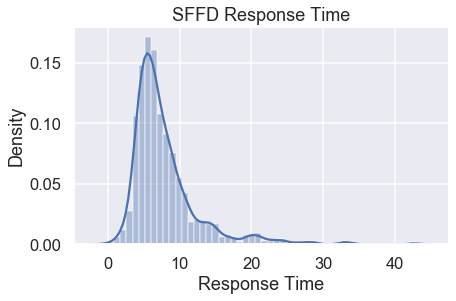

In [584]:
sns.distplot(sffd_dropped["response time"])
plt.title("SFFD Response Time")
plt.ylabel("Density")
plt.xlabel("Response Time");

So most of the response times fall below the 10 minute mark. Let's look at some more visualizations.

C:\Users\am513\anaconda3\lib\site-packages\seaborn\distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\am513\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\am513\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\am513\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\am513\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\am513\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(m

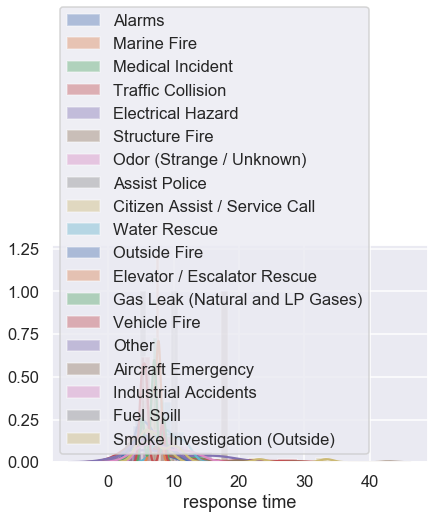

In [585]:
for label in sffd_dropped["call_type"].unique():
    dataz=sffd_dropped[sffd_dropped["call_type"]==label]["response time"]
    sns.distplot(dataz,label=label)
    plt.legend();

Wow that's ugly. Let's take a look at the top 4 entries in ```call_type```

In [586]:
sffd_dropped["call_type"].value_counts()[0:4]

Medical Incident     585
Structure Fire       132
Alarms               118
Traffic Collision     57
Name: call_type, dtype: int64

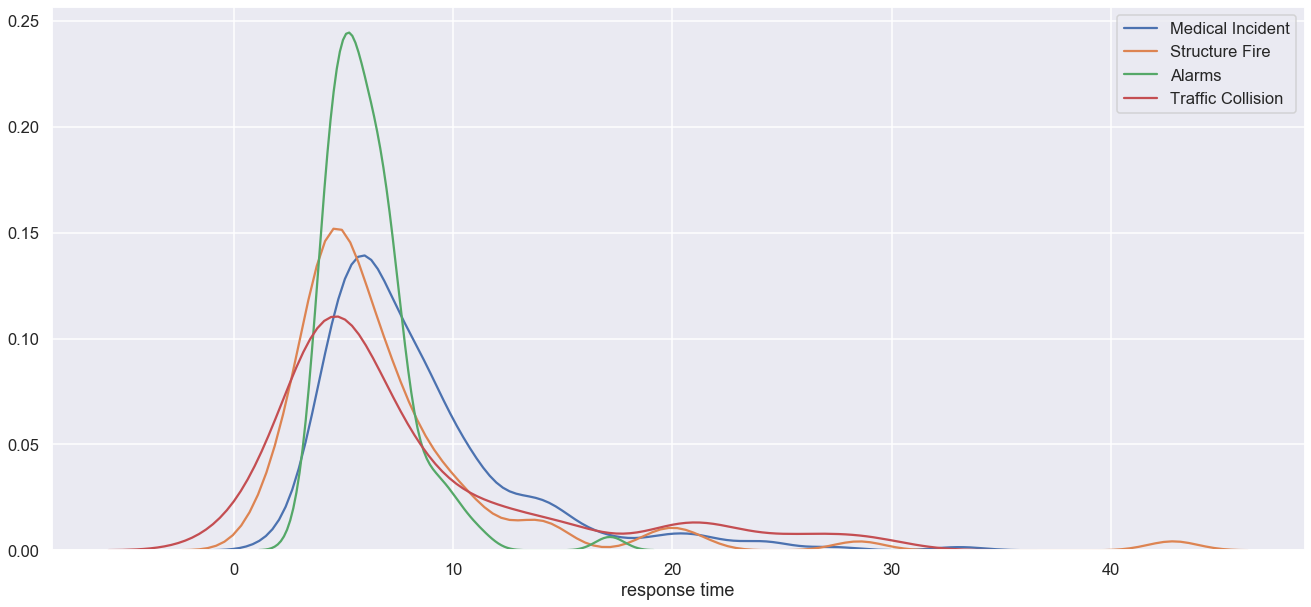

In [587]:
top4=["Medical Incident","Structure Fire","Alarms","Traffic Collision"]

plt.figure(figsize=(20,10))

for labels in top4:
    datazs=sffd_dropped[sffd_dropped["call_type"]==labels]["response time"]
    sns.distplot(datazs,label=labels,hist=False)
    plt.legend();

It seems that traffic collisions have the quickest response time out of the top 4 types of calls followed very closely by structure fires.

# Where are calls coming from?

Let's take a look at where calls are coming from

In [588]:
sffd_dropped["neighborhoods_analysis_boundaries"].value_counts().head()

Tenderloin                        126
Mission                            97
South of Market                    82
Financial District/South Beach     62
Bayview Hunters Point              62
Name: neighborhoods_analysis_boundaries, dtype: int64

In [589]:
sffd_dropped["city"].value_counts().head()

SF     978
TI       5
SFO      4
Name: city, dtype: int64

Seems like the Tenderloin has the highest number of calls. SF has the most amount of call followed by Treasure Island, and then SFO International Airport. Let's see if we can't be more precise in this description. Let's use ```folium``` to create a heat map of calls

In [590]:
import folium
import folium.plugins

sffd_dropped["lats"]=pd.to_numeric(sffd_dropped["location"].str[1:13]) #Commented out to avoid repeat run issues
sffd_dropped["longs"]=pd.to_numeric(sffd_dropped["location"].str[17:32])
sffd_dropped["coords"]=sffd_dropped[["lats","longs"]].values.tolist()

coords_in_sf = (37.756139, -122.433819)
coord_maps = folium.Map(location=coords_in_sf, zoom_start=12)
locations = sffd_dropped[['lats', 'longs']].astype('float').dropna().to_numpy()
heatmap = folium.plugins.HeatMap(locations.tolist(), radius = 10)
coord_maps.add_child(heatmap)

C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Let's mess around with ```folium``` a little more to see if we can glean more information from this dataset. Because I don't want to kill my computer generating a visualization with every single call as a point, I'm going to cluster them.

In [591]:
cluster = folium.plugins.MarkerCluster()
for _, r in sffd_dropped[['lats', 'longs',"call_type"]].dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["lats"]), float(r["longs"])], popup=r["call_type"]))
    
coords_in_sf = (37.756139, -122.433819)
map_in_sf = folium.Map(location=coords_in_sf, zoom_start=12)
map_in_sf.add_child(cluster)
map_in_sf

Seems like a large amount of the calls originated from either a street corner or the middle of the block. Why is this? There are two likely reasons. The first is location is changed to provide the caller privacy. The second is when calls are made, it is likely that the cross street is provided because it is easier to find than a specific address.

In [592]:
sffd_dropped[["address"]]

,address
0,100 Block of CALIFORNIA ST
1,700 Block of THE EMBARCADERO
2,700 Block of PACIFIC AVE
3,500 Block of 14TH ST
4,100 Block of GOUGH ST
...,...
995,600 Block of CLAY ST
996,1900 Block of FRANKLIN ST
997,100 Block of 6TH ST
998,1300 Block of HYDE ST


Let's see if there a specific address that has the most calls

In [593]:
sffd_dropped["coords"]=sffd_dropped[["lats","longs"]].values.tolist()
repeat_callers=sffd_dropped["coords"].value_counts().to_frame().query("coords == 4").index
repeat_callers

C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


Index([     [37.728544474, -122.475646829],
       [37.779666041999995, -122.41371122],
              [37.78502466, -122.41197189],
       [37.616882323, -122.38409423799999],
            [37.784698921, -122.413593512],
       [37.774653476, -122.40511819700001],
            [37.786117211, -122.419854245]],
      dtype='object')

Let's break ```folium``` out again

In [594]:
sf_coords = (37.756139, -122.433819)
more_maps = folium.Map(location=sf_coords, zoom_start=12)
for k in repeat_callers:
    folium.Marker(k,icon=folium.Icon(color="red")).add_to(more_maps)
more_maps

If we look at the points on the map, one is the SF county jail, one is a church, one is a homeless shelter, and one is UN Plaza/Civic Center BART. Let's take a look at the full data associated with these coords

In [595]:
sffd_dropped["coords"]=sffd_dropped[["lats","longs"]].values.tolist()
repeat_callers=sffd_dropped["coords"].value_counts().to_frame()#.query("coords == 4").index
repeat_callers.head().index
    

C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Index([     [37.728544474, -122.475646829],
       [37.779666041999995, -122.41371122],
              [37.78502466, -122.41197189],
       [37.616882323, -122.38409423799999],
            [37.784698921, -122.413593512]],
      dtype='object')

In [599]:
print([37.790072892, -122.39708327299999],"Salesforce Tower")
sffd_dropped.query("lats == 37.784091036 & longs ==-122.411784369")[["call_type",'als_unit','number_of_alarms','unit_type','neighborhoods_analysis_boundaries','hospital_dttm']]

[37.790072892, -122.39708327299999] Salesforce Tower


,call_type,als_unit,number_of_alarms,unit_type,neighborhoods_analysis_boundaries,hospital_dttm
619,Medical Incident,True,1,ENGINE,Tenderloin,NaN
807,Medical Incident,True,1,ENGINE,Tenderloin,NaN
979,Medical Incident,True,1,ENGINE,Tenderloin,NaN


In [600]:
print([37.752239454, -122.41844527200001],"24th Street Mission BART")
sffd_dropped.query("lats == 37.752239454 & longs ==-122.41844527200001")[["call_type",'als_unit','number_of_alarms','unit_type','neighborhoods_analysis_boundaries','hospital_dttm']]

[37.752239454, -122.41844527200001] 24th Street Mission BART


,call_type,als_unit,number_of_alarms,unit_type,neighborhoods_analysis_boundaries,hospital_dttm
128,Alarms,True,1,ENGINE,Mission,NaN
344,Medical Incident,True,1,MEDIC,Mission,NaN


In [601]:
print([37.783569938, -122.408421116],"Saks off 5th")
sffd_dropped.query("lats == 37.783569938 & longs ==-122.408421116")[["call_type",'als_unit','number_of_alarms','unit_type','neighborhoods_analysis_boundaries','hospital_dttm']]

[37.783569938, -122.408421116] Saks off 5th


,call_type,als_unit,number_of_alarms,unit_type,neighborhoods_analysis_boundaries,hospital_dttm


In [602]:
print([37.783565475, -122.4150511362])
sffd_dropped.query("lats == 37.783565475 & longs ==-122.4150511362")[["call_type",'als_unit','number_of_alarms','unit_type','neighborhoods_analysis_boundaries','hospital_dttm']]

[37.783565475, -122.4150511362]


,call_type,als_unit,number_of_alarms,unit_type,neighborhoods_analysis_boundaries,hospital_dttm
776,Alarms,False,1,TRUCK,Tenderloin,NaN


Seems like all these locations are major hubs (BART Stations, high traffic areas) and these landmarks are the closest.

# Time of Day

Let's take a look of when calls are coming in. To make working with datetimes easier, we'll convert them to floats using this equation:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$

In [603]:
sffd_dropped["time float"]=sffd_dropped["recieved dt"].dt.hour+(sffd_dropped["recieved dt"].dt.minute/60)+(sffd_dropped["recieved dt"].dt.second/60**2)

C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


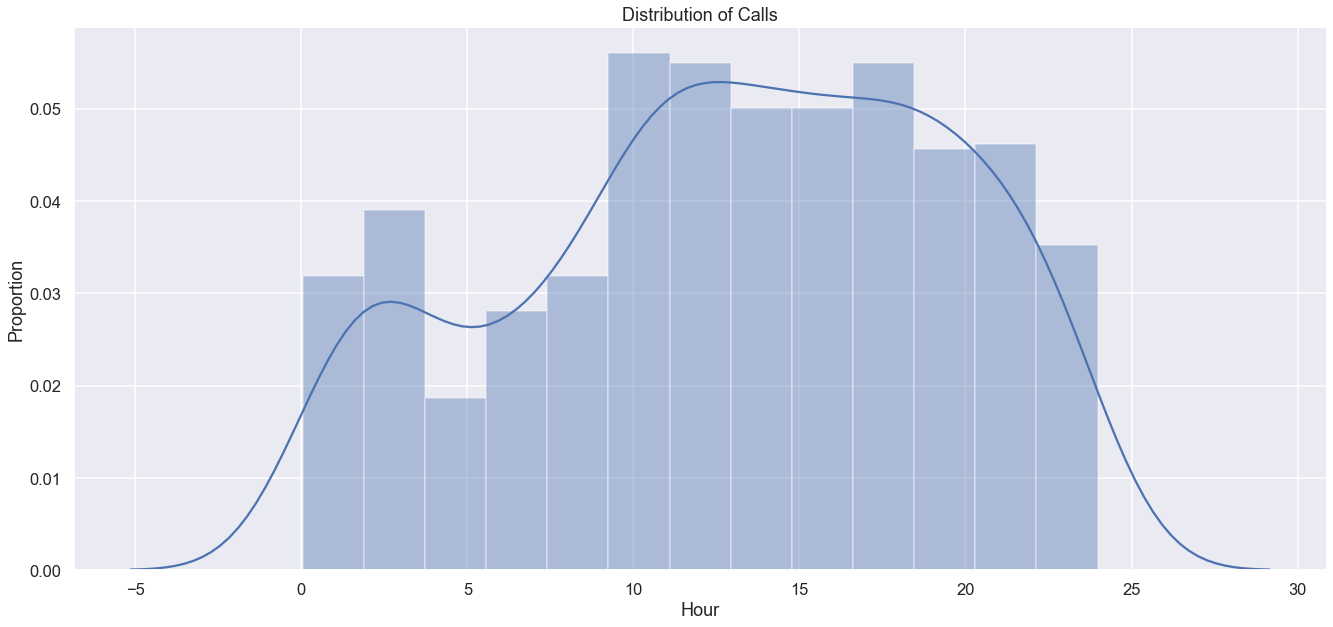

In [604]:
hours=np.arange(0,24)

plt.figure(figsize=(20,10))
sns.distplot(sffd_dropped["time float"],hist=True)
plt.title("Distribution of Calls")
plt.ylabel("Proportion")
plt.xlabel("Hour");

We can see from the KDE that there seems to be call coming in at -5 hours and 25 hours, which obviously don't exist. This is due the smoothing of the KDE. 

So it seems tha around 5AM is the time with the least amount of calls and 10AM has the most.

In [605]:
sffd_dropped["date of the week"]=sffd_dropped["recieved dt"].dt.dayofweek

C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [606]:
sffd_dropped["date of the week"]=sffd_dropped["date of the week"].replace({5:"Sat"})
sffd_dropped["date of the week"]=sffd_dropped["date of the week"].replace({6:"Sun"})
sffd_dropped["date of the week"]=sffd_dropped["date of the week"].replace({4:"Fri"})
sffd_dropped["date of the week"]=sffd_dropped["date of the week"].replace({3:"Thu"})
sffd_dropped["date of the week"]=sffd_dropped["date of the week"].replace({2:"Wed"})
sffd_dropped["date of the week"]=sffd_dropped["date of the week"].replace({1:"Tue"})
sffd_dropped["date of the week"]=sffd_dropped["date of the week"].replace({0:"Mon"})

C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\am513\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Wow. So many error messages. Let's see if it worked

In [608]:
sffd_dropped["date of the week"].head(1)

0    Wed
Name: date of the week, dtype: object

Seems like it worked. Let's do some visualizations

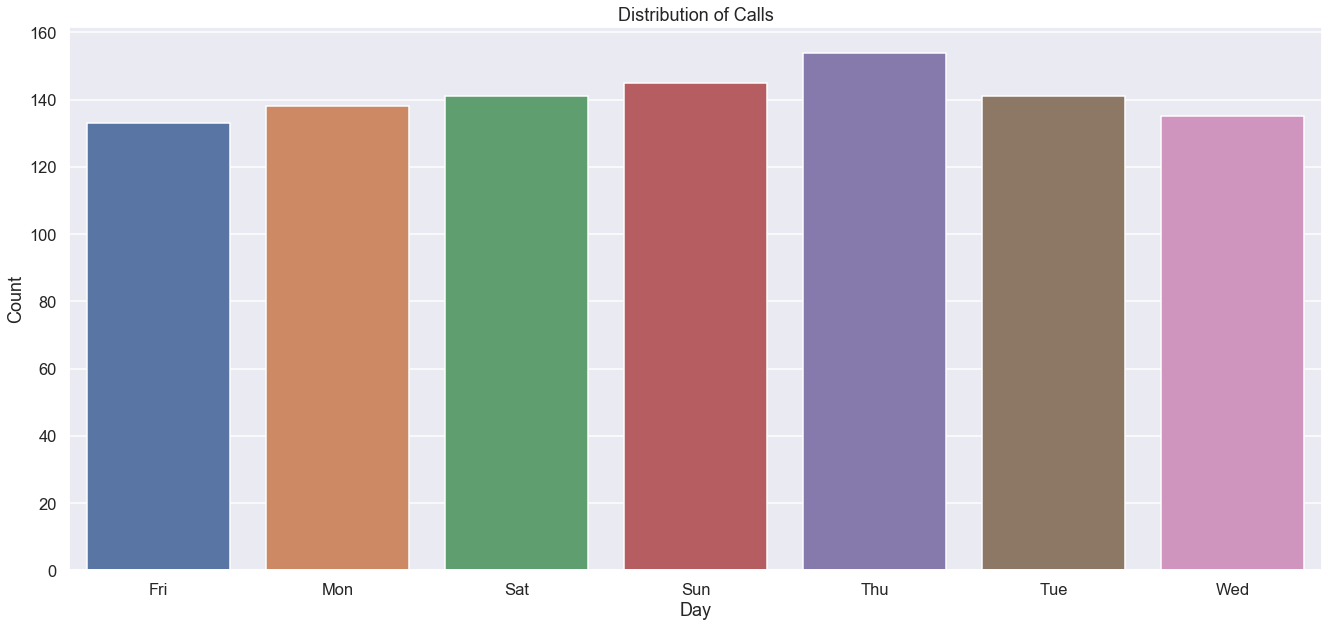

In [609]:
date_count=sffd_dropped.groupby("date of the week").count()["call_number"]
days_of=date_count.index

plt.figure(figsize=(20,10))
sns.barplot(x=days_of,y=date_count)
plt.title("Distribution of Calls")
plt.ylabel("Count")
plt.xlabel("Day");

Seems that the calls seem to be pretty evenly distributed between all the days of the week with Thursday having a slight edge over the other days.

# New Fire Station?

Let's do some analysis which fire stations are responding to the most calls.

In [610]:
sffd_dropped['station_area'].value_counts().head()

1     123
3      74
7      55
13     37
36     36
Name: station_area, dtype: int64

Seems like Fire Station 1 responds the the most calls. Let's see if we can do some more analysis using the fire station locations. Since this data set doesn't already exist (or maybe it does and I can't find it), we have to make it ourselves using the data from this (https://sf-fire.org/fire-station-locations) website and creating a DataFrame. Please note that some stations have been closed down over time (ie. Station 45). Please also note that the station at SFO airport is excluded as well.

In [611]:
sffd_locs=pd.DataFrame({'Station Number':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,48,49,51],
                 'lat':[37.779423,37.797026,37.786630,37.772775,37.780443,37.767050,37.760262,37.777194,37.745245,37.785647,37.748811,37.763545,37.795552,37.779007,37.723487,37.798666,37.727514,37.750977,37.727824,37.751170,37.775473,37.763979,37.761425,37.753131,37.746600,37.740278,37.802547,37.766168,37.779872,37.736444,37.710877,37.779444,37.790199,37.774958,37.757411,37.789665,37.740032,37.747626,37.793402,37.731624,37.716354,37.716655,37.826854,37.740973,37.801625],
                'lon':[-122.404106,-122.410039,-122.419319,-122.389230,-122.430725,-122.430779,-122.415177,-122.396656,-122.401243,-122.446648,-122.426506,-122.452508,-122.401410,-122.485951,-122.452882,-122.436747,-122.385013,-122.490483,-122.478942,-122.456225,-122.440330,-122.473682,-122.504769,-122.441107,-122.386995,-122.433370,-122.409426,-122.404324,-122.470955,-122.421216,-122.458601,-122.502702,-122.388464,-122.421226,-122.399252,-122.429958,-122.458659,-122.475185,-122.416381,-122.405441,-122.431687,-122.400489,-122.369410,-122.385293,-122.455431]})
sffd_locs.head()

,Station Number,lat,lon
0,1,37.779423,-122.404106
1,2,37.797026,-122.410039
2,3,37.786630,-122.419319
3,4,37.772775,-122.389230
4,5,37.780443,-122.430725


That was probably the most tedious thing I've ever done. Anyway, let's pull out ```folium``` again. I think this might be my new favorite visualization package.

In [612]:
sffd_locs["coords"]=sffd_locs[["lat","lon"]].values.tolist()
sffd_locs.head()

,Station Number,lat,lon,coords
0,1,37.779423,-122.404106,"[37.779423, -122.404106]"
1,2,37.797026,-122.410039,"[37.797026, -122.410039]"
2,3,37.786630,-122.419319,"[37.78663, -122.419319]"
3,4,37.772775,-122.389230,"[37.772775, -122.38923]"
4,5,37.780443,-122.430725,"[37.780443, -122.430725]"


In [613]:
coords_in_sf = (37.756139, -122.433819)
coord_maps2 = folium.Map(location=coords_in_sf, zoom_start=12)

locations2 = sffd_dropped[['lats', 'longs']].astype('float').dropna().to_numpy()
heatmap2 = folium.plugins.HeatMap(locations2.tolist(), radius = 10)
coord_maps2.add_child(heatmap2)

for _,k in sffd_locs[["Station Number","lat","lon"]].dropna().iterrows(): 
    folium.Marker([float(k["lat"]),float(k["lon"])], popup=k["Station Number"],icon=folium.Icon(color="blue",icon="fire-extinguisher",prefix="fa")).add_to(coord_maps2)
print("Blue = Fire Station Location")

coord_maps2

Blue = Fire Station Location


In [614]:
sffd_dropped[sffd_dropped["response time"]>average_resp]["station_area"].value_counts().head()

1     45
3     28
7     19
43    18
16    15
Name: station_area, dtype: int64

So if we take a look at the visualization and the subsequent analysis of fire stations with response times above the city average, we see that Station 3 and especially Station 1 have many calls that are above the city average as well as the most calls for service in the city. If we remember from earlier, we found that the Tenderloin had the most calls for service out of any neighborhood in San Francisco. Unsurprisingly, Station 1 and 3 are the closest to the Tenderloin. 

Since the Tenderloin is such a high demand area for fire department service and the existing stations are unable to fully serve the neighborhood, **based on the data, it makes sense for a station to be created in the Tenderloin.** Of course the data we have is from 2006 so it is quite a bit out of date, but based upon the data, this proposal would allievieate the stress on Stations 1 and 3 (allowing those stations to better serve their areas) and help support the underserved Tenderloin area.

# Distance

Let's see what we can do with the coords of fire stations and distance. I've never used any type of GIS or packages involving geography but we'll learn together.

In [615]:
sffd_gis=sffd_dropped[["station_area","coords","response time","lats","longs"]]
sffd_gis_full=sffd_gis.merge(sffd_locs,how="left",left_on="station_area",right_on="Station Number").rename(columns={"coords_x":"Call Coords","coords_y":"Station Coords"})
sffd_gis_drop=sffd_gis_full#[["Station Number","Call Coords","lats","longs","Station Coords","lat","lon","response time"]]
sffd_gis_drop.head()

,station_area,Call Coords,response time,lats,longs,Station Number,lat,lon,Station Coords
0,13,"[37.793488084, -122.398205964]",4.283333,37.793488,-122.398206,13,37.795552,-122.401410,"[37.795552, -122.40141]"
1,35,"[37.802378366, -122.400706378]",NaN,37.802378,-122.400706,35,37.790199,-122.388464,"[37.790199, -122.388464]"
2,2,"[37.796699716999996, -122.40801470299999]",4.750000,37.796700,-122.408015,2,37.797026,-122.410039,"[37.797026, -122.410039]"
3,6,"[37.767958635999996, -122.426119884]",8.666667,37.767959,-122.426120,6,37.767050,-122.430779,"[37.76705, -122.430779]"
4,36,"[37.77430917, -122.42252296299999]",8.700000,37.774309,-122.422523,36,37.774958,-122.421226,"[37.774958, -122.421226]"


In [616]:
from geopy import distance

print(distance.distance(sffd_gis_drop["Station Coords"].iloc[0],sffd_gis_drop["Call Coords"].iloc[0]).feet,"feet")

1192.5083917118 feet


Let's double check this distance with Google Earth. Google Earth confirms that this is indeed 1192 feet. **It should be noted that a limitation of using ```geopy``` is that we don't get the Manhattan/Taxi Cab distance, which is what the fire trucks actually drive (ie. with city blocks and turns).** We have to use Euclidean Distance because of the limitations of coordinates. As long as it is consistent and we know that it isn't the exact route traveled by the truck, we should be fine.

In [617]:
sffd_gis_drop["distance ft"]=sffd_gis_drop.apply(lambda k: distance.distance((k[3],k[4]),(k[6],k[7])).feet,axis=1)
sffd_gis_drop["distance mile"]=sffd_gis_drop.apply(lambda k: distance.distance((k[3],k[4]),(k[6],k[7])).miles,axis=1)

sffd_gis_drop.head()

,station_area,Call Coords,response time,lats,longs,Station Number,lat,lon,Station Coords,distance ft,distance mile
0,13,"[37.793488084, -122.398205964]",4.283333,37.793488,-122.398206,13,37.795552,-122.401410,"[37.795552, -122.40141]",1192.508392,0.225854
1,35,"[37.802378366, -122.400706378]",NaN,37.802378,-122.400706,35,37.790199,-122.388464,"[37.790199, -122.388464]",5673.131783,1.074457
2,2,"[37.796699716999996, -122.40801470299999]",4.750000,37.796700,-122.408015,2,37.797026,-122.410039,"[37.797026, -122.410039]",596.880716,0.113046
3,6,"[37.767958635999996, -122.426119884]",8.666667,37.767959,-122.426120,6,37.767050,-122.430779,"[37.76705, -122.430779]",1386.866652,0.262664
4,36,"[37.77430917, -122.42252296299999]",8.700000,37.774309,-122.422523,36,37.774958,-122.421226,"[37.774958, -122.421226]",443.122901,0.083925


Let's select just some of the columns and do some more analysis

In [618]:
sffd_dist=sffd_gis_drop[["response time","distance ft","distance mile"]]
sffd_dist.head()

,response time,distance ft,distance mile
0,4.283333,1192.508392,0.225854
1,NaN,5673.131783,1.074457
2,4.750000,596.880716,0.113046
3,8.666667,1386.866652,0.262664
4,8.700000,443.122901,0.083925


In [619]:
sffd_dist[sffd_dist["response time"].isnull()].head()

,response time,distance ft,distance mile
1,NaN,5673.131783,1.074457
11,NaN,3608.684865,0.683463
14,NaN,2279.806069,0.431781
16,NaN,3003.443585,0.568834
20,NaN,1842.063656,0.348876


In [620]:
sffd_dist[sffd_dist["response time"].isnull()].index

Int64Index([  1,  11,  14,  16,  20,  21,  23,  33,  34,  42,
            ...
            955, 956, 957, 958, 964, 965, 966, 975, 980, 985],
           dtype='int64', length=216)

In [621]:
sffd_nas=sffd_dropped.iloc[sffd_dist[sffd_dist["response time"].isnull()].index].drop(["call_number","unit_id","incident_number"],axis=1)
sffd_nas.head()

,call_type,call_date,watch_date,received_dttm,entry_dttm,dispatch_dttm,response_dttm,on_scene_dttm,transport_dttm,hospital_dttm,...,on scene dt,date,recieved time,on scene time,response time,lats,longs,coords,time float,date of the week
1,Marine Fire,2006-10-05T00:00:00.000,2006-10-05T15:05:17.000,2006-10-05T15:03:39.000,2006-10-05T15:05:17.000,2006-10-05T15:06:53.000,2006-10-05T15:08:43.000,NaN,NaN,NaN,...,NaT,2006-10-05,15:03:39,NaT,NaN,37.802378,-122.400706,"[37.802378366, -122.400706378]",15.060833,Thu
11,Structure Fire,2006-11-23T00:00:00.000,2006-11-23T14:10:49.000,2006-11-23T14:08:24.000,2006-11-23T14:10:49.000,2006-11-23T14:10:59.000,2006-11-23T14:12:29.000,NaN,NaN,NaN,...,NaT,2006-11-23,14:08:24,NaT,NaN,37.749376,-122.462817,"[37.749375743, -122.46281715399999]",14.140000,Thu
14,Medical Incident,2006-11-17T00:00:00.000,2006-11-17T09:40:14.000,2006-11-17T09:38:36.000,2006-11-17T09:40:14.000,2006-11-17T09:40:37.000,2006-11-17T09:42:01.000,NaN,NaN,NaN,...,NaT,2006-11-17,09:38:36,NaT,NaN,37.728220,-122.447723,"[37.728220134000004, -122.447722565]",9.643333,Fri
16,Structure Fire,2006-08-26T00:00:00.000,2006-08-26T18:00:51.000,2006-08-26T18:00:00.000,2006-08-26T18:00:51.000,2006-08-26T18:01:05.000,2006-08-26T18:02:35.000,NaN,NaN,NaN,...,NaT,2006-08-26,18:00:00,NaT,NaN,37.757947,-122.462145,"[37.757947413000004, -122.462145213]",18.000000,Sat
20,Medical Incident,2006-08-01T00:00:00.000,2006-08-01T09:06:40.000,2006-08-01T09:03:16.000,2006-08-01T09:06:40.000,2006-08-01T09:06:51.000,NaN,NaN,NaN,NaN,...,NaT,2006-08-01,09:03:16,NaT,NaN,37.758930,-122.393175,"[37.758930475999996, -122.39317469]",9.054444,Tue


If we look at these NaN values, it seems that there is no value in the ```on_scene_dttm```, which causes issues with the response time calculations. 

In [622]:
sffd_nas["call_type"].value_counts().head()

Medical Incident     114
Structure Fire        49
Alarms                23
Traffic Collision     15
Other                  4
Name: call_type, dtype: int64

In [623]:
sffd_nas["station_area"].value_counts().head()

1     28
3     23
17     9
32     9
21     8
Name: station_area, dtype: int64

In [624]:
sffd_nas["neighborhoods_analysis_boundaries"].value_counts().head()

Tenderloin                        33
Bayview Hunters Point             21
South of Market                   17
Mission                           13
Financial District/South Beach    12
Name: neighborhoods_analysis_boundaries, dtype: int64

If we remember from earlier, all of these are expected. The highest count of ```call_type``` was Medical Incident, Stations 1 and 3 had the most calls, and the Tenderloin had the most calls. So it's probably safe to drop the NaN rows.

In [625]:
sffd_dist_drop=sffd_dist.dropna(subset=["response time"],axis=0)
sffd_dist_drop.head()

,response time,distance ft,distance mile
0,4.283333,1192.508392,0.225854
2,4.750000,596.880716,0.113046
3,8.666667,1386.866652,0.262664
4,8.700000,443.122901,0.083925
5,4.600000,2521.581393,0.477572


In [626]:
sffd_dist_drop.sort_values("distance mile",ascending=False).head(8)

,response time,distance ft,distance mile
520,5.933333,3.576213e+07,6773.131391
677,19.916667,3.061579e+07,5798.444761
952,4.900000,3.061528e+07,5798.347778
509,6.983333,3.061528e+07,5798.347778
500,4.716667,3.061497e+07,5798.290366
282,6.483333,3.060914e+07,5797.185000
622,6.200000,3.060151e+07,5795.740821
525,6.166667,3.060069e+07,5795.585696


6773 miles!?! That can't be right! Almost all the calls are within SF, which is much smaller than 6773 miles large. What's up with this?

In [627]:
sffd_gis_drop.loc[sffd_dist_drop.sort_values("distance mile",ascending=False).head(8).index]

,station_area,Call Coords,response time,lats,longs,Station Number,lat,lon,Station Coords,distance ft,distance mile
520,31,"[37.786288101, 22.473255083245]",5.933333,37.786288,22.473255,31,37.779872,-122.470955,"[37.779872, -122.470955]",3.576213e+07,6773.131391
677,7,"[37.760951688, 122.42066714738002]",19.916667,37.760952,122.420667,7,37.760262,-122.415177,"[37.760262, -122.415177]",3.061579e+07,5798.444761
952,7,"[37.762135706, 122.42168942688]",4.900000,37.762136,122.421689,7,37.760262,-122.415177,"[37.760262, -122.415177]",3.061528e+07,5798.347778
509,7,"[37.762135706, 122.42168942688]",6.983333,37.762136,122.421689,7,37.760262,-122.415177,"[37.760262, -122.415177]",3.061528e+07,5798.347778
500,7,"[37.763299769, 122.42173152365]",4.716667,37.763300,122.421732,7,37.760262,-122.415177,"[37.760262, -122.415177]",3.061497e+07,5798.290366
282,1,"[37.781760908, 122.41510513501001]",6.483333,37.781761,122.415105,1,37.779423,-122.404106,"[37.779423, -122.404106]",3.060914e+07,5797.185000
622,41,"[37.790698768, 122.41162121008999]",6.200000,37.790699,122.411621,41,37.793402,-122.416381,"[37.793402, -122.416381]",3.060151e+07,5795.740821
525,5,"[37.781534508, 122.4281353075]",6.166667,37.781535,122.428135,5,37.780443,-122.430725,"[37.780443, -122.430725]",3.060069e+07,5795.585696


That makes more sense. There are errors in the lat/lon data entry. Most seem to be missing a negative sign in the longitude. I don't think SFFD responded to the middle of the Yellow Sea.

In [628]:
sffd_dropped.loc[sffd_dist_drop.sort_values("distance mile",ascending=False).head(8).index][["station_area"]]

,station_area
520,42
677,1
952,9
509,12
500,38
282,3
622,3
525,3


In [629]:
sffd_dropped.loc[sffd_dist_drop.sort_values("distance mile",ascending=False).head(8).index][["call_type"]]

,call_type
520,Medical Incident
677,Medical Incident
952,Medical Incident
509,Medical Incident
500,Medical Incident
282,Structure Fire
622,Medical Incident
525,Medical Incident


In [630]:
sffd_dropped.loc[sffd_dist_drop.sort_values("distance mile",ascending=False).head(8).index][["neighborhoods_analysis_boundaries"]]

,neighborhoods_analysis_boundaries
520,Bayview Hunters Point
677,Tenderloin
952,Mission
509,Golden Gate Park
500,Pacific Heights
282,Tenderloin
622,Tenderloin
525,Tenderloin


I think these are just random errors, so we'll just drop them.

In [631]:
sffd_dist_drop2=sffd_dist_drop.drop((sffd_dist_drop.sort_values("distance mile",ascending=False).head(8).index),axis=0)
sffd_dist_drop2.head()

,response time,distance ft,distance mile
0,4.283333,1192.508392,0.225854
2,4.750000,596.880716,0.113046
3,8.666667,1386.866652,0.262664
4,8.700000,443.122901,0.083925
5,4.600000,2521.581393,0.477572


In [632]:
shortest_distance=np.round(sffd_dist_drop2.sort_values("distance ft").iloc[0][1],decimals=2)
longest_distance=np.round(sffd_dist_drop2.sort_values("distance mile",ascending=False).iloc[0][2],decimals=2)
print("The longest call distance was",longest_distance,"miles and the shortest was",shortest_distance,"feet")

The longest call distance was 6.94 miles and the shortest was 49.65 feet


In [633]:
avg_ft=np.round(np.mean(sffd_dist_drop2["distance ft"]),decimals=2)
avg_mile=np.round(np.mean(sffd_dist_drop2["distance mile"]),decimals=3)
print("The average distance is",avg_mile,"miles which is",avg_ft,"feet")

The average distance is 0.434 miles which is 2294.07 feet


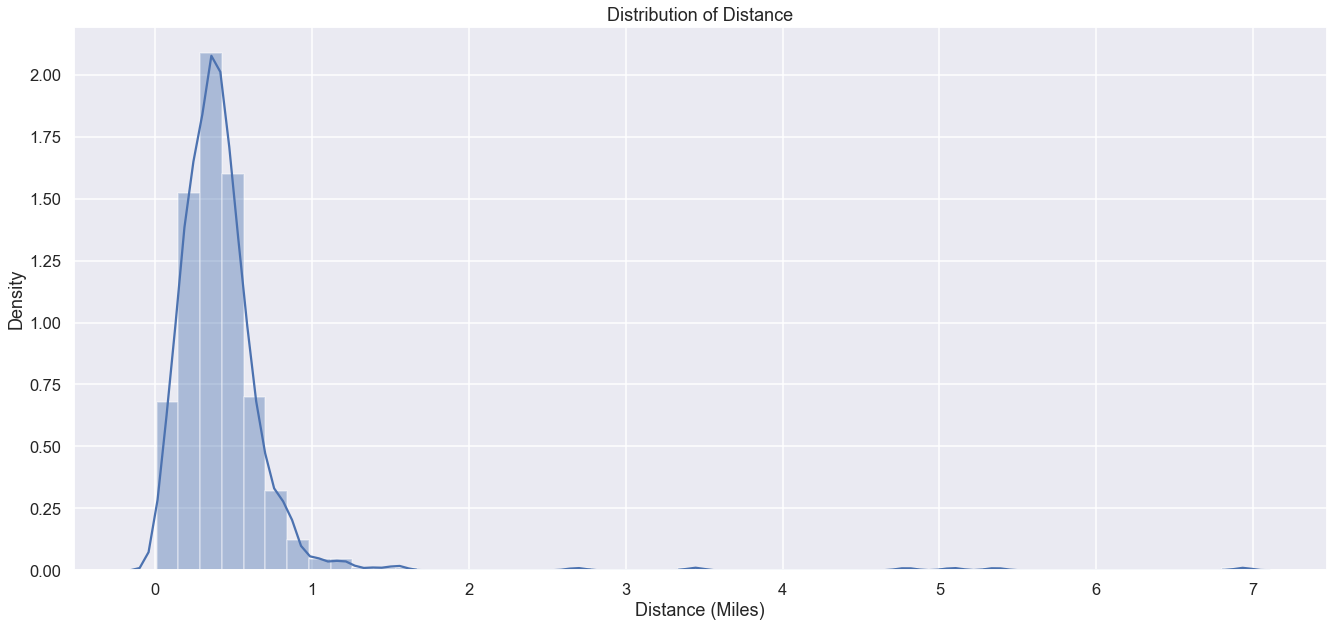

In [634]:
plt.figure(figsize=(20,10))
sns.distplot(sffd_dist_drop2["distance mile"])
plt.xlabel("Distance (Miles)")
plt.title("Distribution of Distance")
plt.ylabel("Density");

Seems like almost all distances are 1 mile or less, which is pretty good for response times as we saw earlier. (There are also no negative distances. This is caused by the KDE)

# End

That's it for this notebook. Check out a summary of everything that happened up at the top of the notebook. Thanks for taking a look and I hope you learned something! 